In [ ]:
!pip install easyocr
!pip install imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 32.6 MB/s eta 0:00:00


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

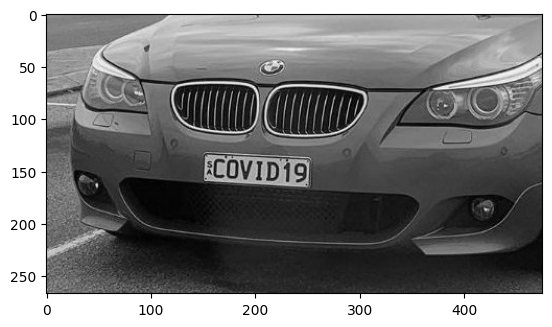

In [ ]:
img = cv2.imread('image2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

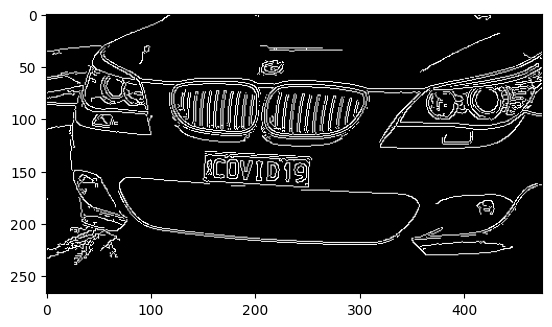

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [ ]:
location = None
print("Debugging 4-sided contours and their aspect ratios:")
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        if h > 0: # Avoid division by zero
            aspect_ratio = w / float(h)
            print(f"  Found 4-sided contour with aspect ratio: {aspect_ratio:.2f}")
            # A typical license plate aspect ratio is between 2 and 5
            if 2 < aspect_ratio < 5:
                location = approx
                print(f"  -> Selected location with aspect ratio: {aspect_ratio:.2f}")
                break
        else:
            print("  Found 4-sided contour with height 0, skipping aspect ratio calculation.")

if location is None:
    print("No suitable number plate location found after checking all 4-sided contours.")

Debugging 4-sided contours and their aspect ratios:
  Found 4-sided contour with aspect ratio: 3.45
  -> Selected location with aspect ratio: 3.45


In [ ]:
location

array([[[152, 136]],

       [[248, 139]],

       [[251, 164]],

       [[153, 160]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
if location is not None:
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)
else:
    print("No suitable number plate location found. Setting new_image to a blank image.")
    new_image = np.zeros_like(img)


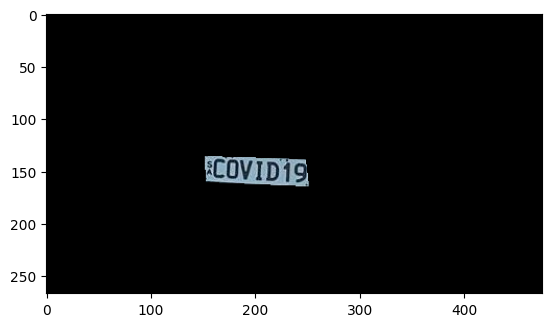

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

Let's visualize the `location` detected as the number plate on the original image to ensure the contour detection is working correctly. This will help us understand if the issue is with identifying the plate region or with the OCR itself.

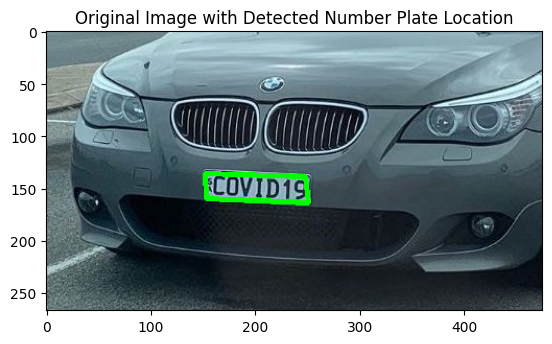

In [ ]:
img_with_location = img.copy()
if location is not None:
    cv2.drawContours(img_with_location, [location], -1, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(img_with_location, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Detected Number Plate Location')
    plt.show()
else:
    print("No number plate location was detected, so cannot display it on the original image.")
    plt.imshow(cv2.cvtColor(img_with_location, cv2.COLOR_BGR2RGB)) # Still show the original image
    plt.title('Original Image (No Number Plate Detected)')
    plt.show()


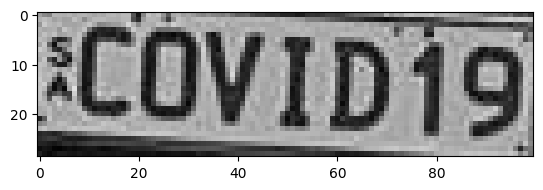

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[0, 0], [100, 0], [100, 29], [0, 29]],
  'ICOVIDT9',
  np.float64(0.5350357625980823))]

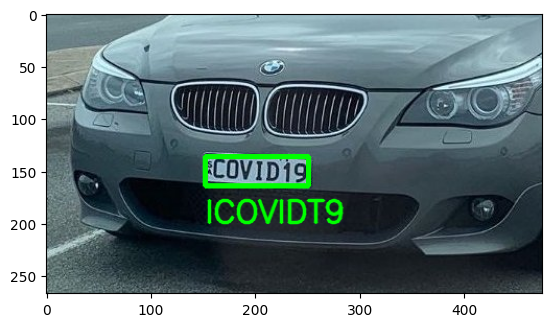

In [ ]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))